In [1]:
#MLE assigment

In [20]:
#load the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from scipy.stats import zscore
from sklearn.ensemble import IsolationForest
import random
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb
import optuna
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import root_mean_squared_error


In [2]:
# Load dataset
file_path = "MLE-Assignment.csv"
df = pd.read_csv(file_path)

In [3]:
# 1. Check for missing values
missing_values = df.isnull().sum().sum()
print(f"Total missing values: {missing_values}")

Total missing values: 0


In [4]:
# 2. Summary statistics for the target variable
target_col = "vomitoxin_ppb"
print("\nTarget Variable Statistics:")
print(df[target_col].describe())


Target Variable Statistics:
count       500.000000
mean       3410.006000
std       13095.803483
min           0.000000
25%         137.500000
50%         500.000000
75%        1700.000000
max      131000.000000
Name: vomitoxin_ppb, dtype: float64


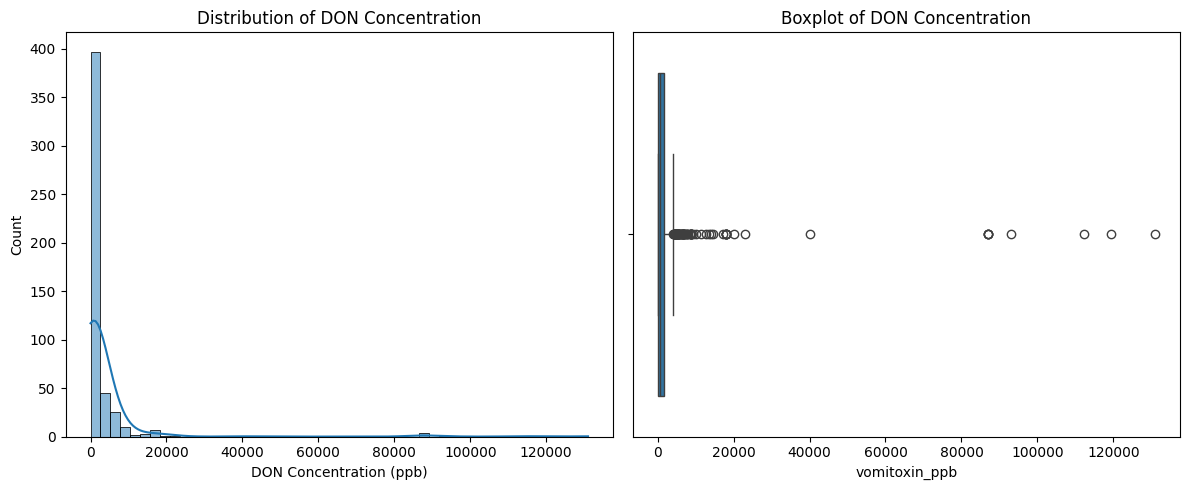

In [5]:
# 3. Plot histogram and boxplot of the target variable
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df[target_col], bins=50, kde=True, ax=axes[0])
axes[0].set_title("Distribution of DON Concentration")
axes[0].set_xlabel("DON Concentration (ppb)")
sns.boxplot(x=df[target_col], ax=axes[1])
axes[1].set_title("Boxplot of DON Concentration")
plt.tight_layout()
plt.show()

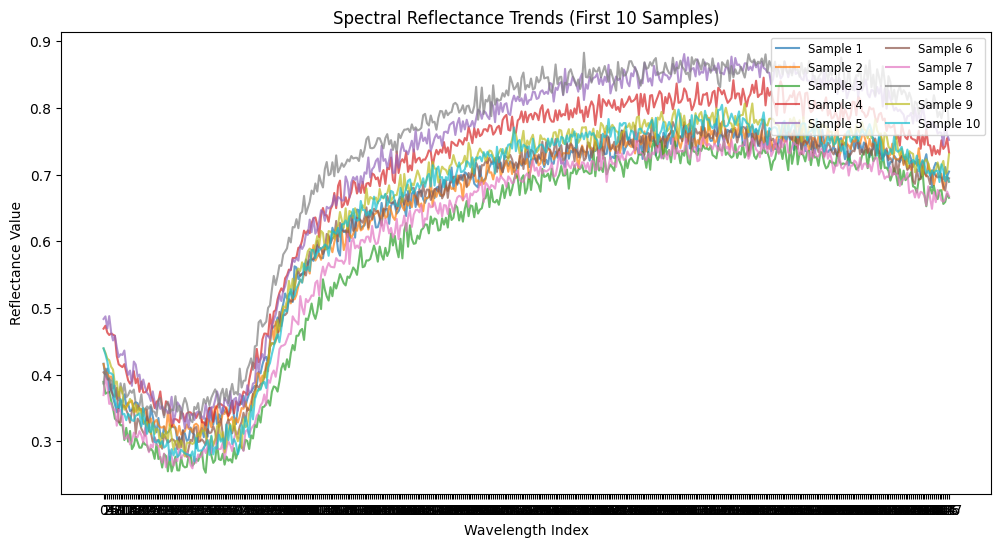

In [6]:
# 4. Visualize spectral reflectance trends (first 10 samples)
sample_spectra = df.iloc[:10, 1:-1].T  # Exclude 'hsi_id' and target column
plt.figure(figsize=(12, 6))
for i in range(sample_spectra.shape[1]):
    plt.plot(sample_spectra.index, sample_spectra.iloc[:, i], alpha=0.7, label=f'Sample {i+1}')
plt.title("Spectral Reflectance Trends (First 10 Samples)")
plt.xlabel("Wavelength Index")
plt.ylabel("Reflectance Value")
plt.legend(loc="upper right", fontsize="small", ncol=2)
plt.show()

In [7]:
# 5. Anomaly Detection
# Z-score method
z_scores = np.abs(zscore(df[target_col]))
z_threshold = 3  # Common threshold
outliers_zscore = np.where(z_scores > z_threshold)[0]
print(f"Detected {len(outliers_zscore)} anomalies using Z-score method.")

Detected 8 anomalies using Z-score method.


In [8]:
# 5. Anomaly Detection
# IQR method
Q1 = df[target_col].quantile(0.25)
Q3 = df[target_col].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers_iqr = df[(df[target_col] < lower_bound) | (df[target_col] > upper_bound)].index
print(f"Detected {len(outliers_iqr)} anomalies using IQR method.")

Detected 80 anomalies using IQR method.


In [9]:
# 5. Anomaly Detection
# Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)

# Normalize spectral data (Min-Max Scaling)
scaler = MinMaxScaler()
X = df.iloc[:, 1:-1]  # Exclude 'hsi_id' and target
X_scaled = scaler.fit_transform(X)
y = df[target_col].values

anomaly_preds = iso_forest.fit_predict(X_scaled)
df['anomaly'] = anomaly_preds
num_anomalies = (df['anomaly'] == -1).sum()
print(f"Detected {num_anomalies} anomalies using Isolation Forest.")

Detected 25 anomalies using Isolation Forest.


In [10]:
# 6. Remove Z-score detected anomalies
df_cleaned = df.drop(index=outliers_zscore).reset_index(drop=True)
print(f"Dataset size after removing anomalies: {df_cleaned.shape[0]} samples")

Dataset size after removing anomalies: 492 samples


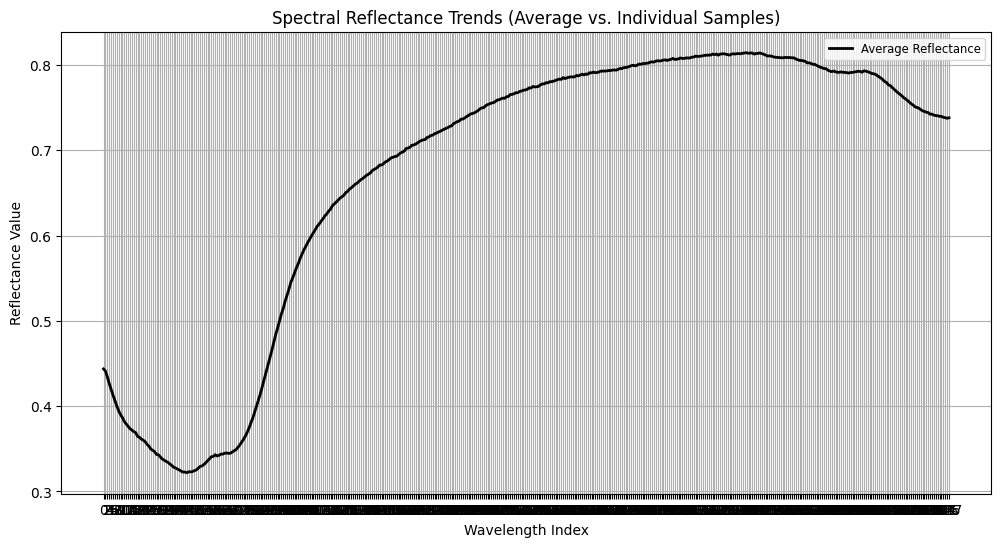

In [11]:
# 7. Average reflectance over wavelengths

# Compute the average reflectance over all samples for each wavelength
average_reflectance = df_cleaned.iloc[:, 1:-1].mean(axis=0)
average_reflectance.drop(average_reflectance.tail(1).index,
        inplace = True)

# Plot the average reflectance
plt.figure(figsize=(12, 6))
plt.plot(average_reflectance.index, average_reflectance.values, 
         color='black', linestyle='-', linewidth=2, label='Average Reflectance')

# Labels and title
plt.title("Spectral Reflectance Trends (Average vs. Individual Samples)")
plt.xlabel("Wavelength Index")
plt.ylabel("Reflectance Value")
plt.legend(loc="upper right", fontsize="small", ncol=2)
plt.grid(True)

# Show plot
plt.show()

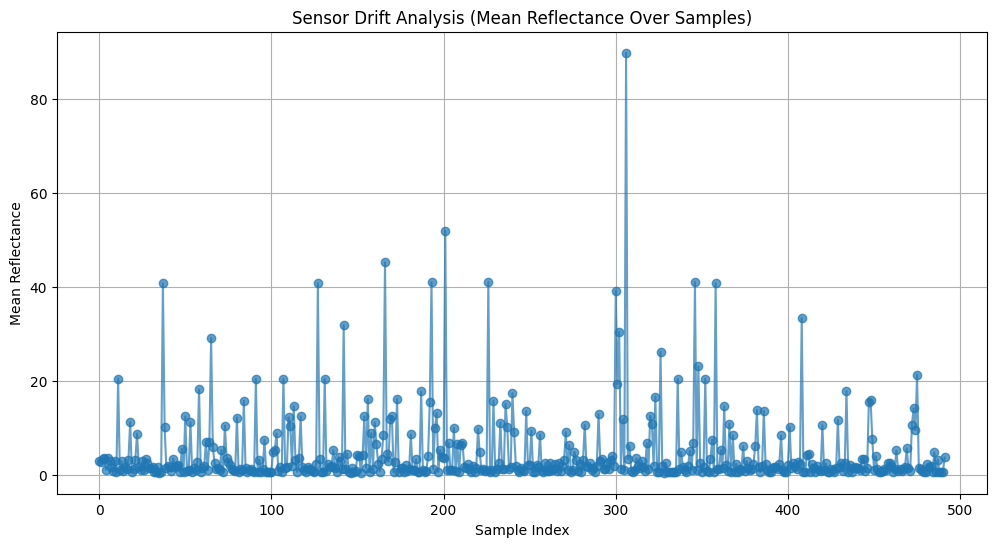

In [12]:
# 8. Sensor Drift Detection

df_cleaned["mean_reflectance"] = df_cleaned.iloc[:, 1:-1].mean(axis=1)

plt.figure(figsize=(12, 6))
plt.plot(df_cleaned["mean_reflectance"], marker='o', linestyle='-', alpha=0.7)
plt.title("Sensor Drift Analysis (Mean Reflectance Over Samples)")
plt.xlabel("Sample Index")
plt.ylabel("Mean Reflectance")
plt.grid(True)
plt.show()

In [13]:
# 8. Detect Sudden Jumps (Data Inconsistencies)

df_cleaned["reflectance_diff"] = df_cleaned["mean_reflectance"].diff().abs()
threshold = df_cleaned["reflectance_diff"].mean() + 3 * df_cleaned["reflectance_diff"].std()
inconsistent_samples = df_cleaned[df_cleaned["reflectance_diff"] > threshold]

In [14]:
# 8. Remove the inconsistent samples

# Remove inconsistent samples
df_filtered = df_cleaned[df_cleaned["reflectance_diff"] <= threshold].drop(columns=["reflectance_diff"])

print(f"Removed {len(inconsistent_samples)} inconsistent samples. New dataset size: {df_filtered.shape}")


Removed 16 inconsistent samples. New dataset size: (475, 452)


In [ ]:
# Part 2: model training

In [ ]:
# 1. Normalize spectral data (Min-Max Scaling)
scaler = MinMaxScaler()
X = df_filtered.iloc[:, 1:-1]  # Exclude 'hsi_id' and target
X_scaled = scaler.fit_transform(X)
y = df_filtered[target_col].values

# 2. Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")

Training samples: 380, Testing samples: 95


In [15]:
# Define a function to create the Neural Network model
def create_nn_model(input_shape, units=64, layers_count=3, dropout_rate=0.2):
    model = keras.Sequential()
    model.add(layers.InputLayer(input_shape=input_shape))

    for _ in range(layers_count):
        model.add(layers.Dense(units, activation="relu"))
        model.add(layers.Dropout(dropout_rate))

    model.add(layers.Dense(1, activation="linear"))  # Regression output
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    
    return model


In [22]:
# 3.Train Baseline Neural Network

input_shape = X_train.shape[1:]  # Feature shape
nn_model = create_nn_model(input_shape)
nn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

#Evaluate the model
y_pred_nn = nn_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred_nn)
rmse = root_mean_squared_error(y_test, y_pred_nn)
r2 = r2_score(y_test, y_pred_nn)

print(f"\nNeural Network Model Performance:")
print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, R² Score: {r2:.4f}")

Epoch 1/50


/Users/admin/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 8036472.5000 - mae: 1424.6956 - val_loss: 7747142.0000 - val_mae: 1422.9224
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 11117679.0000 - mae: 1645.9437 - val_loss: 7656019.5000 - val_mae: 1403.4355
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8617468.0000 - mae: 1508.8092 - val_loss: 7429908.0000 - val_mae: 1358.4722
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9964603.0000 - mae: 1505.7360 - val_loss: 7000402.0000 - val_mae: 1308.5327
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 11721756.0000 - mae: 1700.0150 - val_loss: 6411013.5000 - val_mae: 1361.4442
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9631403.0000 - mae: 1648.7030 - val_loss: 6177574.5000 - val_mae: 1560.5721
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 6569312.5000 - mae: 1645.4702 - val_loss: 6262029.0000 - val_mae: 1696.6360
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 77514

In [23]:
# 3.Hyperparameter Optimization using Optuna
def objective(trial):
    units = trial.suggest_int("units", 32, 128)
    layers_count = trial.suggest_int("layers_count", 1, 4)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    
    model = create_nn_model(input_shape, units, layers_count, dropout_rate)
    model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0, validation_data=(X_test, y_test))
    
    y_pred = model.predict(X_test)
    return mean_absolute_error(y_test, y_pred)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

print("\nBest Hyperparameters:", study.best_params)

[I 2025-03-14 12:08:55,248] A new study created in memory with name: no-name-b58d214d-e178-41b8-942f-bbb7ab27b7fc
/Users/admin/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


[I 2025-03-14 12:09:01,953] Trial 0 finished with value: 1576.9437218917044 and parameters: {'units': 34, 'layers_count': 4, 'dropout_rate': 0.33892075071922567}. Best is trial 0 with value: 1576.9437218917044.
/Users/admin/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


[I 2025-03-14 12:09:09,062] Trial 1 finished with value: 1554.2835150467722 and parameters: {'units': 70, 'layers_count': 4, 'dropout_rate': 0.43457928779308286}. Best is trial 1 with value: 1554.2835150467722.
/Users/admin/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


[I 2025-03-14 12:09:15,085] Trial 2 finished with value: 1353.3739039772436 and parameters: {'units': 100, 'layers_count': 1, 'dropout_rate': 0.4048642762565524}. Best is trial 2 with value: 1353.3739039772436.
/Users/admin/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


[I 2025-03-14 12:09:23,331] Trial 3 finished with value: 1535.6336180034436 and parameters: {'units': 90, 'layers_count': 4, 'dropout_rate': 0.4563047086440063}. Best is trial 2 with value: 1353.3739039772436.
/Users/admin/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


[I 2025-03-14 12:09:32,015] Trial 4 finished with value: 1576.1721066926655 and parameters: {'units': 38, 'layers_count': 3, 'dropout_rate': 0.36799113913873327}. Best is trial 2 with value: 1353.3739039772436.
/Users/admin/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


[I 2025-03-14 12:09:41,790] Trial 5 finished with value: 1615.159662347091 and parameters: {'units': 78, 'layers_count': 3, 'dropout_rate': 0.32195420132137875}. Best is trial 2 with value: 1353.3739039772436.
/Users/admin/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


[I 2025-03-14 12:09:50,055] Trial 6 finished with value: 1367.9973656102231 and parameters: {'units': 88, 'layers_count': 1, 'dropout_rate': 0.25473183193684046}. Best is trial 2 with value: 1353.3739039772436.
/Users/admin/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-03-14 12:09:58,586] Trial 7 finished with value: 1335.282523667185 and parameters: {'units': 78, 'layers_count': 1, 'dropout_rate': 0.23322696984667776}. Best is trial 7 with value: 1335.282523667185.
/Users/admin/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[I 2025-03-14 12:10:05,906] Trial 8 finished with value: 1333.6277611581902 and parameters: {'units': 87, 'layers_count': 1, 'dropout_rate': 0.29995355558261005}. Best is trial 8 with value: 1333.6277611581902.
/Users/admin/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step


[I 2025-03-14 12:10:14,756] Trial 9 finished with value: 1574.830768464741 and parameters: {'units': 101, 'layers_count': 3, 'dropout_rate': 0.22212378537683258}. Best is trial 8 with value: 1333.6277611581902.



Best Hyperparameters: {'units': 87, 'layers_count': 1, 'dropout_rate': 0.29995355558261005}


In [24]:
#Train the optimized model

best_params = study.best_params
optimized_nn_model = create_nn_model(input_shape, best_params["units"], best_params["layers_count"], best_params["dropout_rate"])
optimized_nn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

#Evaluate the model
y_pred_nn = optimized_nn_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred_nn)
rmse = root_mean_squared_error(y_test, y_pred_nn)
r2 = r2_score(y_test, y_pred_nn)

print(f"\nOptimized Neural Network Model Performance:")
print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, R² Score: {r2:.4f}")

Epoch 1/50


/Users/admin/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 10266713.0000 - mae: 1562.8136 - val_loss: 7748235.0000 - val_mae: 1423.2021
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9013881.0000 - mae: 1459.8033 - val_loss: 7718295.0000 - val_mae: 1416.8727
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 12582366.0000 - mae: 1890.7754 - val_loss: 7681724.5000 - val_mae: 1409.0615
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9092591.0000 - mae: 1443.3683 - val_loss: 7639881.5000 - val_mae: 1400.0062
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8414195.0000 - mae: 1427.7823 - val_loss: 7589951.5000 - val_mae: 1389.4305
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8000548.5000 - mae: 1316.9965 - val_loss: 7532330.0000 - val_mae: 1377.5327
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9164744.0000 - mae: 1505.9574 - val_loss: 7466589.0000 - val_mae: 1365.1265
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 94358

In [25]:
# 4. Other models: XGBoost & LightGBM
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

lgb_model = lgb.LGBMRegressor(n_estimators=100)
lgb_model.fit(X_train, y_train)
y_pred_lgb = lgb_model.predict(X_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 56948
[LightGBM] [Info] Number of data points in the train set: 380, number of used features: 449
[LightGBM] [Info] Start training from score 1544.228947
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

/Users/admin/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [26]:
# 5. Evaluate the models

def evaluate_model(y_test, y_pred, model_name):
    mae = mean_absolute_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"\n{model_name} Performance: MAE: {mae:.4f}, RMSE: {rmse:.4f}, R² Score: {r2:.4f}")

evaluate_model(y_test, y_pred_nn, "Neural Network")
evaluate_model(y_test, y_pred_xgb, "XGBoost")
evaluate_model(y_test, y_pred_lgb, "LightGBM")


Neural Network Performance: MAE: 1621.5109, RMSE: 2488.0714, R² Score: -0.0797

XGBoost Performance: MAE: 57.3225, RMSE: 215.7421, R² Score: 0.9919

LightGBM Performance: MAE: 299.7755, RMSE: 640.8835, R² Score: 0.9284


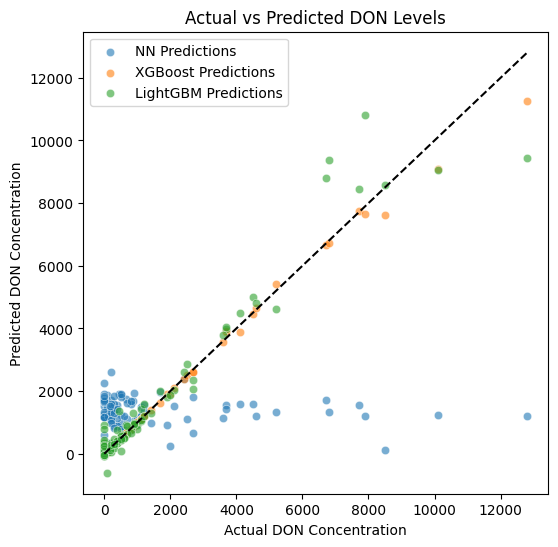

In [27]:
# 6. Visualize Predictions

plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred_nn.flatten(), label="NN Predictions", alpha=0.6)
sns.scatterplot(x=y_test, y=y_pred_xgb, label="XGBoost Predictions", alpha=0.6)
sns.scatterplot(x=y_test, y=y_pred_lgb, label="LightGBM Predictions", alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle="--", color="black")
plt.xlabel("Actual DON Concentration")
plt.ylabel("Predicted DON Concentration")
plt.legend()
plt.title("Actual vs Predicted DON Levels")
plt.show()

PermutationExplainer explainer: 96it [02:08,  1.41s/it]                        
/var/folders/lj/1fkt9p5950q_xh36l9svgyyw0000gn/T/ipykernel_70885/2803901570.py:10: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test)


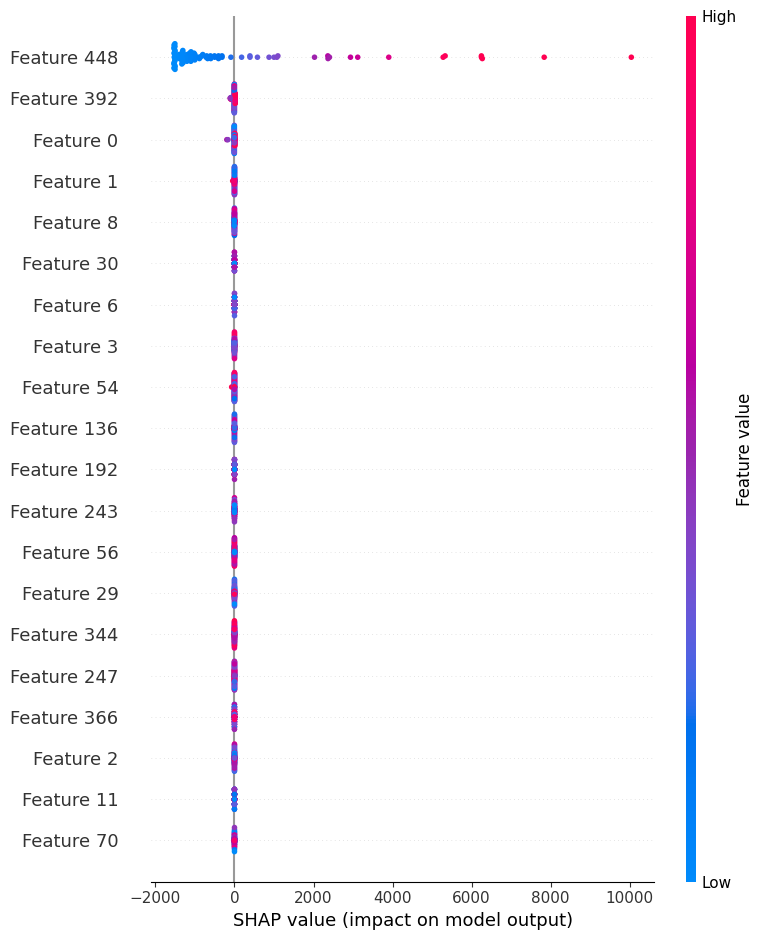

In [29]:
# 7. Explain the models with SHAP
import shap
# Create SHAP explainer for the trained model
explainer = shap.Explainer(xgb_model.predict, X_train, max_evals=901)

# Get SHAP values for the test set
shap_values = explainer(X_test)

# Summary plot: Shows overall feature importance
shap.summary_plot(shap_values, X_test)

In [30]:
# 8. LIME
from lime.lime_tabular import LimeTabularExplainer

# Create LIME explainer
explainer = LimeTabularExplainer(X_train, mode="regression")

# Choose a test sample to explain
sample_idx = 0
exp = explainer.explain_instance(X_test[sample_idx], xgb_model.predict)

# Show the explanation
exp.show_in_notebook()

In [ ]:
# Part 4: Pipeline Integration & Production-Readiness

In [32]:
# 1. Logging

import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

def preprocess_data(df):
    """Handles missing values and scales the spectral data."""
    logging.info("Starting data preprocessing...")
    
    if df.isnull().sum().sum() > 0:
        logging.warning(f"Found {df.isnull().sum().sum()} missing values! Filling with median.")
        df.fillna(df.median(), inplace=True)

    logging.info("Normalizing spectral data...")
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(df.iloc[:, 1:-1])  # Exclude ID and target column
    y = df.iloc[:, -1].values  # Target variable

    return X_scaled, y


In [ ]:
# 2. Unit tests

import pytest
from model_pipeline import preprocess_data  # Import from your main script

def test_preprocess_data():
    """Test if preprocessing correctly handles missing values and normalization."""
    data = {
        "id": [1, 2, 3],
        "wavelength1": [0.1, np.nan, 0.3],
        "wavelength2": [0.2, 0.5, 0.8],
        "vomitoxin_ppb": [10, 15, 20]
    }
    df = pd.DataFrame(data)

    X_scaled, y = preprocess_data(df)

    assert X_scaled.shape == (3, 2)  # Check dimensions
    assert not np.isnan(X_scaled).any()  # Ensure no missing values
    assert y.tolist() == [10, 15, 20]  # Check target values

ModuleNotFoundError: No module named 'model_pipeline'

In [ ]:
#3. Deploy model as API

from fastapi import FastAPI, HTTPException
import pickle
import numpy as np
import pandas as pd

# Load trained model
with open("model.pkl", "rb") as f:
    model = pickle.load(f)

app = FastAPI()

@app.get("/")
def home():
    return {"message": "DON Prediction API is running"}

@app.post("/predict/")
def predict(data: dict):
    try:
        features = np.array(data["features"]).reshape(1, -1)
        prediction = model.predict(features)[0]
        return {"predicted_DON_ppb": prediction}
    except Exception as e:
        raise HTTPException(status_code=400, detail=str(e))